In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Input, Activation, BatchNormalization
from keras import regularizers, optimizers
from keras.utils import np_utils
from keras.layers.merge import add
import sklearn

In [ ]:
genome_poster_score = np.load("/content/drive/MyDrive/Colab Notebooks/poster2genres/data/genome_poster_score.npy")
movie_poster = np.load("/content/drive/MyDrive/Colab Notebooks/poster2genres/data/movie_poster_id.npy")
movie_poster = movie_poster/255

In [ ]:
poster_train, poster_test, genome_train, genome_test = train_test_split(movie_poster, genome_poster_score, test_size = 0.2)
del movie_poster, genome_poster_score

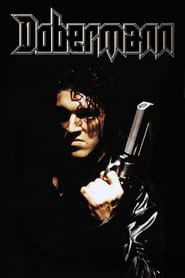

In [ ]:
cv2_imshow(poster_test[0]*255)

In [ ]:
# building model
INPUT_SHAPE = Input(shape=(278, 185, 3))
x1 = Conv2D(32, (5, 5), strides=[2,2], padding='same')(INPUT_SHAPE)
x1 = MaxPooling2D(pool_size=(3, 3), strides=[2,2])(x1)
    # First residual block: RES BLOCK 1
x2 = BatchNormalization()(x1)
x2 = Activation('relu')(x2)
x2 = Conv2D(32, (3, 3), strides=[2,2], padding='same',
      kernel_initializer="he_normal",
      kernel_regularizer=regularizers.l2(1e-4))(x2)

x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x2 = Conv2D(32, (3, 3), padding='same',
      kernel_initializer="he_normal",
      kernel_regularizer=regularizers.l2(1e-4))(x2)

x1 = Conv2D(32, (1, 1), strides=[2,2], padding='same')(x1)
x3 = add([x1, x2])

    # Second residual block: RES BLOCK 2
x4 = BatchNormalization()(x3)
x4 = Activation('relu')(x4)
x4 = Conv2D(64, (3, 3), strides=[2,2], padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x4)

x4 = BatchNormalization()(x4)
x4 = Activation('relu')(x4)
x4 = Conv2D(64, (3, 3), padding='same',
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(1e-4))(x4)

x3 = Conv2D(64, (1, 1), strides=[2,2], padding='same')(x3)
x5 = add([x3, x4])

    # Third residual block: RES BLOCK 3
x6 = BatchNormalization()(x5)
x6 = Activation('relu')(x6)
x6 = Conv2D(128, (3, 3), strides=[2,2], padding='same',
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(1e-4))(x6)

x6 = BatchNormalization()(x6)
x6 = Activation('relu')(x6)
x6 = Conv2D(128, (3, 3), padding='same',
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(1e-4))(x6)

x5 = Conv2D(128, (1, 1), strides=[2,2], padding='same')(x5)
x7 = add([x5, x6])

    #Flatten 
x8 = Flatten()(x7)
x8 = Activation('relu')(x8)
x8 = Dropout(0.5)(x8)

x9 = Dense(2256, activation = "relu")(x8)
x9 = Dropout(0.5)(x9)
result =  Dense(1128, activation = 'sigmoid')(x9)

model = Model(inputs=[INPUT_SHAPE], outputs=[result])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 278, 185, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 139, 93, 32)  2432        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 69, 46, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 69, 46, 32)   128         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
batch_sz = 64
epoch = 40
Ntrain = poster_train.shape[0]
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='mse', metrics='mae')    
save_best = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/model_checkpoint/best_poster_to_gerne.hdf5", monitor='val_mae', 
                                verbose=1, save_best_only=True, mode='min', period=1)
save_all = save_all = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/model_checkpoint/all_poster_to_gerne.hdf5", 
                                    verbose=1, period=5)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.1,
                              patience=10, verbose=1, mode="min", min_lr=0.00000001)
model.fit(x=poster_train, y=genome_train, batch_size=batch_sz, 
            epochs=epoch,
            steps_per_epoch=int(np.ceil(Ntrain/batch_sz)),
            validation_data=(poster_test, genome_test),
            validation_steps=int(np.ceil(poster_test.shape[0] / batch_sz)),
            callbacks= [save_best, save_all, reduce_lr])

Epoch 1/40
130/130 [==============================] - 135s 1s/step - loss: 0.0741 - mae: 0.0802 - val_loss: 0.0525 - val_mae: 0.1240

Epoch 00001: val_mae improved from inf to 0.12404, saving model to /content/drive/MyDrive/Colab Notebooks/model_checkpoint/best_poster_to_gerne.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
130/130 [==============================] - 132s 1s/step - loss: 0.0350 - mae: 0.0729 - val_loss: 0.0281 - val_mae: 0.0887

Epoch 00002: val_mae improved from 0.12404 to 0.08871, saving model to /content/drive/MyDrive/Colab Notebooks/model_checkpoint/best_poster_to_gerne.hdf5
Epoch 3/40
130/130 [==============================] - 132s 1s/step - loss: 0.0236 - mae: 0.0721 - val_loss: 0.0202 - val_mae: 0.0732

Epoch 00003: val_mae improved from 0.08871 to 0.07316, saving model to /content/drive/MyDrive/Colab Notebooks/model_checkpoint/best_poster_to_gerne.hdf5
Epoch 4/40
130/130 [==============================] - 132s 1s/step - loss: 0.0187 - mae: 0.0712 - val_loss: 0.0174 - val_mae: 0.0689

Epoch 00004: val_mae improved from 0.07316 to 0.06894, saving model to /content/drive/MyDrive/Colab Notebooks/model_checkpoint/best_poster_to_gerne.hdf5
Epoch 5/40
130/130 [==============================] - 133s 1s/step - loss: 0.0166 - mae: 0.0702 - val_loss: 0.0164 - val_mae: 0.0705

Epoch

In [ ]:
model.predict(poster_test[0].reshape([1,278,185,3]))

array([[0.04411641, 0.04127744, 0.06316373, ..., 0.04287657, 0.13861683,
        0.03629109]], dtype=float32)

In [ ]:
genome_test[0]

array([0.02225, 0.025  , 0.027  , ..., 0.0065 , 0.0735 , 0.01625])